# Customer clustering


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl # colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
import pickle
import sys

from IPython.display import display # to print tables inside the code cell

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['figure.dpi'] = 60
plt.rcParams['savefig.bbox'] = 'tight'

Study customer grouping. The idea is to cluster customers into groups of common products, so that we can run one RNN model per group with as small number of products as possible (OHE method). Is this data good for such custering?

Let's study customer pairs and calculate cosine similarity (CosSim) between two customers. CosSim is defined as $N_c/\sqrt{N_1*N_2}$, where $N_1, N_2$, and $N_c$ are the number of products for the first and the second customer in the pair, and the number of common products between them. Let's built a CosSim matrix and check basic characteristics.

### 1.1 Input files <a id='1.1'></a>

Let's read in the files, set up some memory control and select from the file orders only those orders that correspond to train sample (prior and next orders).

In [2]:
orders         = pd.read_csv("./data/orders.csv",usecols=['order_id','user_id','eval_set','order_number'])
products_prior = pd.read_csv("./data/order_products__prior.csv")
products_train = pd.read_csv("./data/order_products__train.csv")
#products_sub   = pd.read_csv("./data/sample_submission.csv")

print(orders.shape)
print(products_prior.shape) 
print(products_train.shape) 
#print(products_sub.shape)

(3421083, 4)
(32434489, 4)
(1384617, 4)


In [3]:
orders.head(15)

,order_id,user_id,eval_set,order_number
0,2539329,1,prior,1
1,2398795,1,prior,2
2,473747,1,prior,3
3,2254736,1,prior,4
4,431534,1,prior,5
5,3367565,1,prior,6
6,550135,1,prior,7
7,3108588,1,prior,8
8,2295261,1,prior,9
9,2550362,1,prior,10


In [4]:
products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
products_prior.shape, products_train.shape

((32434489, 4), (1384617, 4))

### 1.2 Select train-sample users <a id='1.2'></a>

Select only those customers who belong to the train sample (remove the test sample) 

In [7]:
uid = orders.groupby('user_id')['eval_set'].unique()
uid

user_id
1         [prior, train]
2         [prior, train]
3          [prior, test]
4          [prior, test]
5         [prior, train]
               ...      
206205    [prior, train]
206206     [prior, test]
206207     [prior, test]
206208     [prior, test]
206209    [prior, train]
Name: eval_set, Length: 206209, dtype: object

In [8]:
uid_train = uid[uid.astype('str').str.contains('train')].reset_index()
uid_train = uid_train.drop('eval_set',axis=1)
uid_train.head()

,user_id
0,1
1,2
2,5
3,7
4,8


Now, let's select the above customers from the order sample:

In [9]:
orders_train = uid_train.merge(orders,on='user_id',how='left').drop('eval_set',axis=1)
orders_train

,user_id,order_id,order_number
0,1,2539329,1
1,1,2398795,2
2,1,473747,3
3,1,2254736,4
4,1,431534,5
...,...,...,...
2178581,206209,2266710,10
2178582,206209,1854736,11
2178583,206209,626363,12
2178584,206209,2977660,13


### 1.3 Merge with products <a id='1.3'></a>

And let's merge with products datasets:

In [10]:
products = pd.concat((products_prior,products_train))
products.shape

(33819106, 4)

In [11]:
products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [12]:
o = orders_train.merge(products,on='order_id',how='left').drop(['add_to_cart_order','order_id'],axis=1)
o.head(20)

,user_id,order_number,product_id,reordered
0,1,1,196,0
1,1,1,14084,0
2,1,1,12427,0
3,1,1,26088,0
4,1,1,26405,0
5,1,2,196,1
6,1,2,10258,0
7,1,2,12427,1
8,1,2,13176,0
9,1,2,26088,1


How many products per user? Summed over all the customer's orders:

In [13]:
o.groupby('user_id')['product_id'].agg(['count','nunique'])

,count,nunique
user_id,,
1,70,19
2,226,121
5,46,28
7,215,69
8,67,50
...,...,...
206199,349,142
206200,298,103
206203,132,85


How many products per customer, all and reordered:

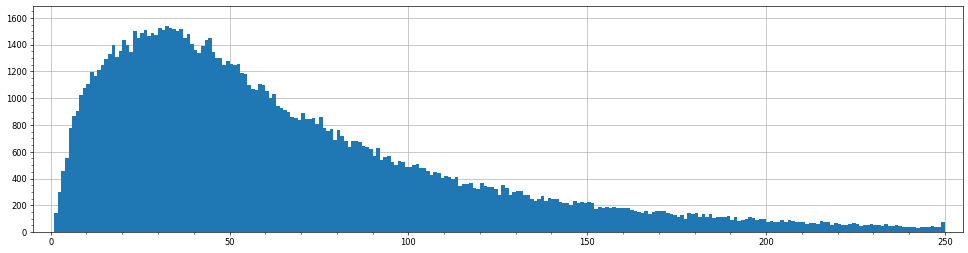

In [14]:
o.groupby('user_id')['product_id'].nunique().hist(bins=250,range=(0,250),figsize=(20,5));

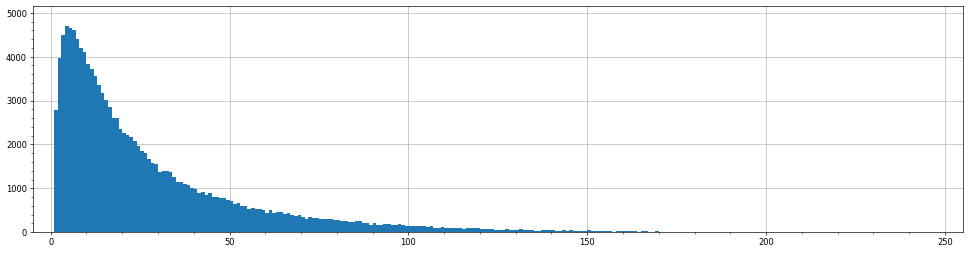

In [15]:
o[o['reordered'] == 1].groupby('user_id')['product_id'].nunique().hist(bins=250,range=(0,250),figsize=(20,5));

In [16]:
o.groupby('user_id')['product_id'].unique()

user_id
1         [196, 14084, 12427, 26088, 26405, 10258, 13176...
2         [32792, 47766, 20574, 12000, 48110, 22474, 165...
5         [15349, 21413, 48775, 28289, 8518, 11777, 3171...
7         [45628, 39275, 6361, 45066, 13249, 31683, 519,...
8         [21903, 28985, 6473, 39110, 39812, 20920, 3203...
                                ...                        
206199    [14493, 38930, 7781, 10305, 44446, 49198, 1033...
206200    [17878, 47209, 38996, 25931, 13176, 31040, 403...
206203    [15693, 21469, 37188, 10749, 26209, 31717, 110...
206205    [27845, 28745, 3896, 49235, 21137, 37067, 3873...
206209    [6846, 9405, 41213, 40396, 14901, 40534, 23039...
Name: product_id, Length: 131209, dtype: object

In [17]:
ou = o[o['reordered'] == 1].groupby('user_id')['product_id'].unique()
ou

user_id
1         [196, 12427, 26088, 10258, 25133, 26405, 13176...
2         [47766, 32792, 20574, 12000, 9681, 32139, 2734...
5         [43693, 24535, 11777, 26604, 40706, 21413, 139...
7         [29871, 22963, 6361, 31683, 45066, 37999, 4562...
8         [9839, 14992, 2078, 17794, 23165, 21903, 28985...
                                ...                        
206199    [42504, 38930, 10305, 44446, 49198, 10333, 423...
206200    [17878, 38996, 13176, 47209, 28553, 42265, 219...
206203    [15693, 37188, 21469, 31727, 26209, 10749, 388...
206205    [27845, 39160, 21137, 43352, 3896, 22035, 3873...
206209    [41213, 9405, 20073, 25837, 13176, 6846, 40534...
Name: product_id, Length: 130412, dtype: object

In [18]:
type(ou)

pandas.core.series.Series

In [19]:
ou.iloc[0]

array([  196, 12427, 26088, 10258, 25133, 26405, 13176, 13032, 49235,
       46149, 38928, 39657])

### 1.4 Cosine similarity between customer pairs <a id='1.4'></a>

For the moment, let's do only the first 10k out of 130k customers:

In [20]:
ou = ou.head(10000)

In [21]:
msize = ou.shape[0]
msize
#full: 130412

10000

In [22]:
# define cosine similarity function between a pair of products
import math

def CosSim_score(y_cust1, y_cust2):
    
    y_cust1 = set(y_cust1) - {0}
    y_cust2 = set(y_cust2) - {0}
    
    len_cust1  = len(y_cust1)
    len_cust2  = len(y_cust2)
    len_union = len(y_cust1 & y_cust2)
    
    # both empty
    if len_cust1 + len_cust2 == 0:
        return 0.,0.,0.

    # nothing in common (includes both: none vs sth and sth vs none, so no division by zero below)
    if len_union == 0: 
        return 0.,0.,0.
    
    fra1 = 1. * len_union / len_cust1
    fra2 = 1. * len_union / len_cust2
    cossim = 1. * len_union / math.sqrt(len_cust1 * len_cust2)
    
    return fra1, fra2, cossim

Now calculate for each pair of customers (symmetric matrix, so skip its upper half)

In [23]:
t0 = dt.now()

csa = np.zeros((msize,msize),dtype='int16')
fr1a = np.zeros((msize,msize),dtype='int16')
fr2a = np.zeros((msize,msize),dtype='int16')

for i in range(ou.shape[0]):
    for j in range(i):
        
        if i%10000 == 0:
            if j%10000 == 0:
                
                th = dt.now()
                dth = round((th-t0).total_seconds()/60.,2)
                print(i,j,' time from start (min)=',dth)
                
#        print(i,ou.iloc[i])
#        print(j,ou.iloc[j])

        cs = CosSim_score(ou.iloc[i],ou.iloc[j])

        if(cs[2]>0): 
            
#            print(i,j,cs)
            fr1a[i][j] = round(1000.*cs[0])
            fr2a[i][j] = round(1000.*cs[1])
            csa[i][j]  = round(1000.*cs[2])
            
t1 = dt.now()
print('time (min) = ',round((t1-t0).total_seconds()/60.,2))

time (min) =  14.26


In [24]:
with open('./data/cust_clust.pkl', 'wb') as f:
        pickle.dump((fr1a,fr2a,csa), f)

In [25]:
csa = csa/1000.
fr1a  = fr1a/1000.
fr2a  = fr2a/1000.

In [27]:
csa

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.052, 0.028, 0.114, ..., 0.   , 0.   , 0.   ],
       [0.029, 0.063, 0.032, ..., 0.073, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [28]:
np.min(csa),np.max(csa)

(0.0, 1.0)

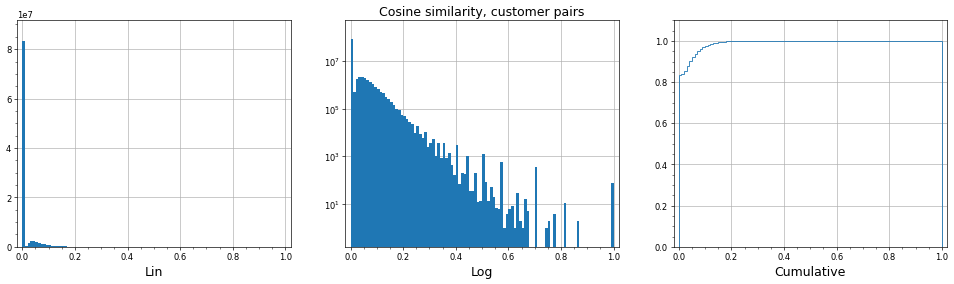

In [29]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].hist(csa.ravel(),bins=100)
ax[1].hist(csa.ravel(),bins=100,log=True)
ax[2].hist(csa.ravel(),bins=100,cumulative=True,density=True,histtype='step')
ax[1].set_title('Cosine similarity, customer pairs',fontsize=15)
ax[0].set_xlabel('Lin',fontsize=15)
ax[1].set_xlabel('Log',fontsize=15)
ax[2].set_xlabel('Cumulative',fontsize=15);

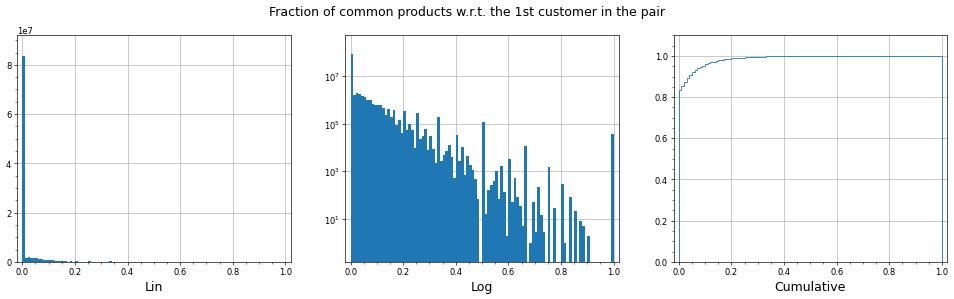

In [30]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].hist(fr1a.ravel(),bins=100)
ax[1].hist(fr1a.ravel(),bins=100,log=True)
ax[2].hist(fr1a.ravel(),bins=100,cumulative=True,density=True,histtype='step')
fig.suptitle('Fraction of common products w.r.t. the 1st customer in the pair',fontsize=15)
ax[0].set_xlabel('Lin',fontsize=15)
ax[1].set_xlabel('Log',fontsize=15)
ax[2].set_xlabel('Cumulative',fontsize=15);

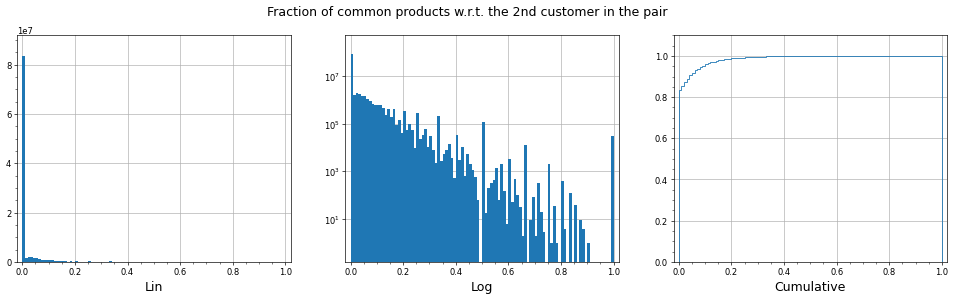

In [31]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].hist(fr2a.ravel(),bins=100)
ax[1].hist(fr2a.ravel(),bins=100,log=True)
ax[2].hist(fr2a.ravel(),bins=100,cumulative=True,density=True,histtype='step')
fig.suptitle('Fraction of common products w.r.t. the 2nd customer in the pair',fontsize=15)
ax[0].set_xlabel('Lin',fontsize=15)
ax[1].set_xlabel('Log',fontsize=15)
ax[2].set_xlabel('Cumulative',fontsize=15);

Copy into dataframe:

In [33]:
df = pd.DataFrame(data=csa,index=ou.index,columns=ou.index)

In [34]:
df.head(20)

user_id,1,2,5,7,8,9,10,13,14,17,...,15723,15724,15725,15726,15727,15728,15730,15731,15735,15737
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000,0.048,0.049,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000,0.085,0.058,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.000,0.000,0.057,0.028,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Show the matrix for the fist 100 customers:

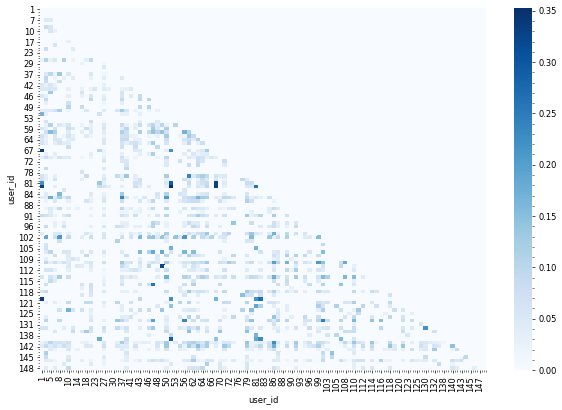

In [35]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(df.iloc[:100,:100],cmap='Blues',ax=ax);

What's the max cs value in each column:

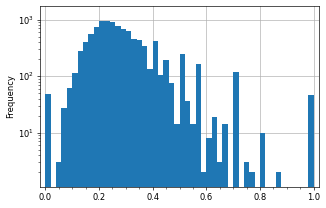

In [36]:
df.max().plot.hist(bins=50,log=True);

TO DO: Think about a matching algorithm to custer the customers into groups that share the maximum number of products.